# Walmart Sales Prediction
-----
>In this second phase of the project, we will try to:  

>> find out which model best suits this prediction problem   
>> understand which predictors might have high impact on the prediction outputs

------

### Table of Contents

* [1. Load Data](#section1)
* [2. Linear Regression Models](#section2)
    * [2.1. Data Preparing for Modeling](#section21)
    * [2.2. Dummy Regressor](#section22)
    * [2.3. Linear Regressor](#section23)
    * [2.4. Ridge Regressor](#section24)
    * [2.5. Lasso Regressor](#section25)
    * [2.6. Features Importance](#section26)
* [3. Summary](#section3)

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Generic librairies 
import pandas as pd
pd.options.display.max_columns=None

import numpy as np

# Visualization librairies 
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe" 


# Machine learning librairies
# split
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# score metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# model selection
from sklearn.model_selection import cross_val_score, GridSearchCV

# predefined modules
from modules import MyFunctions as MyFunct

# Global parameters 
filepath = 'data/prep_walmart_sales.csv'
results_path='results/'

 ## Load data

In [2]:
print("Loading dataset...")
dataset = pd.read_csv(filepath)
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
MyFunct.explore(dataset)

Shape : (6297, 8)

data types : 
Store           float64
Weekly_Sales    float64
Holiday_Flag    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week            float64
dtype: object

Display of dataset: 


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week
0,1.0,1643690.90,0.0,42.31,2.572,211.096358,8.106,5.0
1,1.0,1641957.44,1.0,38.51,2.548,211.242170,8.106,6.0
2,1.0,1611968.17,0.0,39.93,2.514,211.289143,8.106,7.0
3,1.0,1409727.59,0.0,46.63,2.561,211.319643,8.106,8.0
4,1.0,1554806.68,0.0,46.50,2.625,211.350143,8.106,9.0



Basics statistics: 


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week
count,6297.000000,6.297000e+03,6286.000000,6283.000000,6285.000000,6286.000000,6283.000000,6279.000000
mean,22.722566,1.055463e+06,0.069997,60.433589,3.359432,173.251996,7.780878,25.900621
std,13.069591,5.693211e+05,0.255162,18.487402,0.461103,39.150100,1.512723,14.125355
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,1.000000
25%,11.000000,5.570752e+05,0.000000,46.970000,2.915000,132.586532,6.881000,14.000000
50%,22.000000,9.619933e+05,0.000000,62.590000,3.467000,188.274383,7.852000,26.000000
75%,34.000000,1.438383e+06,0.000000,74.830000,3.735000,213.206962,8.521000,38.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,13.503000,52.000000



Distinct values: 


Store             45
Weekly_Sales    6216
Holiday_Flag       3
Temperature     3495
Fuel_Price       881
CPI             2158
Unemployment     358
Week              53
dtype: int64

# Linear Regression Models

## Data Preparing for Modeling

>Linear regression has five key assumptions:

>>(1) X and y are linearly related,  
(2) the features in X are independant    
(3) Residuals are independent   
(4) Residuals are normally distributed    
(5) Residuals have the same variance (Homoscedasticity)   

In [4]:
# Define target variable (y) and explanatory variables (X)
Y = dataset['Weekly_Sales']
X = dataset.drop('Weekly_Sales', axis = 'columns')

In [5]:
# Divide dataset 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Convert pandas DataFrames to numpy arrays before using scikit-learn
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

# Create pipeline for numeric features 
#Num_X =['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week'] 
num_X = [2,3,4,5,6]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
#cat_X = ['Store', 'Holiday_Flag']
cat_X = [0,1]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

# Use ColumnTranformer to make a preprocessor object 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_X),
        ('cat', categorical_transformer, cat_X)
    ])

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [6]:
# categories and features'names
categories = preprocessor.transformers_[1][1].named_steps['encoder'].categories_
print(f'categories: {categories}')
features = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names()
print(f'features: {features}')

categories: [array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.]), array([0., 1.])]
features: ['x0_2.0' 'x0_3.0' 'x0_4.0' 'x0_5.0' 'x0_6.0' 'x0_7.0' 'x0_8.0' 'x0_9.0'
 'x0_10.0' 'x0_11.0' 'x0_12.0' 'x0_13.0' 'x0_14.0' 'x0_15.0' 'x0_16.0'
 'x0_17.0' 'x0_18.0' 'x0_19.0' 'x0_20.0' 'x0_21.0' 'x0_22.0' 'x0_23.0'
 'x0_24.0' 'x0_25.0' 'x0_26.0' 'x0_27.0' 'x0_28.0' 'x0_29.0' 'x0_30.0'
 'x0_31.0' 'x0_32.0' 'x0_33.0' 'x0_34.0' 'x0_35.0' 'x0_36.0' 'x0_37.0'
 'x0_38.0' 'x0_39.0' 'x0_40.0' 'x0_41.0' 'x0_42.0' 'x0_43.0' 'x0_44.0'
 'x0_45.0' 'x1_1.0']


## Dummy Regressor

In [7]:
dummy_regressor = DummyRegressor(strategy = 'mean')
dummy_regressor.fit(X_train, Y_train)

y_train_pred, y_test_pred= dummy_regressor.predict(X_train), dummy_regressor.predict(X_test)
mse_train, mse_test = mean_squared_error(Y_train,y_train_pred ), mean_squared_error(Y_test, y_test_pred)
r2_train, r2_test = r2_score(Y_train,y_train_pred), r2_score(Y_test, y_test_pred)
adjR2_train, adjR2_test = MyFunct.adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]), MyFunct.adjusted_r2(r2_test, X_train.shape[0], X_train.shape[1]) 

iterables = [["RMSE", "R2", "ADJ R2"], ["Train", "Test"]]
ind = pd.MultiIndex.from_product(iterables)

metrics = pd.DataFrame(columns=['Dummy Regressor'], index = ind)
metrics['Dummy Regressor'] = [np.sqrt(mse_train), np.sqrt(mse_test), r2_train, r2_test, adjR2_train, adjR2_test]
metrics

Dummy Regressor
RMSE   Train    567328.360407
       Test     576996.112490
R2     Train         0.000000
       Test         -0.000009
ADJ R2 Train        -0.010028
       Test         -0.010037

## Linear Regressor

In [8]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)

y_train_pred, y_test_pred= linear_regressor.predict(X_train), linear_regressor.predict(X_test)
mse_train, mse_test = mean_squared_error(Y_train,y_train_pred ), mean_squared_error(Y_test, y_test_pred)
r2_train, r2_test = r2_score(Y_train,y_train_pred), r2_score(Y_test, y_test_pred)
adjR2_train, adjR2_test = MyFunct.adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]), MyFunct.adjusted_r2(r2_test, X_train.shape[0], X_train.shape[1]) 

# compute SS for the F_value computation
SST1, SSR1, SSE1 = MyFunct.sum_squares(Y_train, y_train_pred)

metrics['Linear Regressor'] = [np.sqrt(mse_train), np.sqrt(mse_test), r2_train, r2_test,adjR2_train, adjR2_test]
metrics

Dummy Regressor  Linear Regressor
RMSE   Train    567328.360407     152726.329640
       Test     576996.112490     156892.312389
R2     Train         0.000000          0.927530
       Test         -0.000009          0.926063
ADJ R2 Train        -0.010028          0.926803
       Test         -0.010037          0.925322

**Observation** The Dummy Regressor always predict the r2_ score as 0 since it is always predicting a constant (mean) without having an insight of the output. The Linear Regression Model seems to fit much better than the Dummy Regressor in terms of “mean squared error” and “r2_score”. 

## Ridge Regressor 

<AxesSubplot:xlabel='param_alpha'>

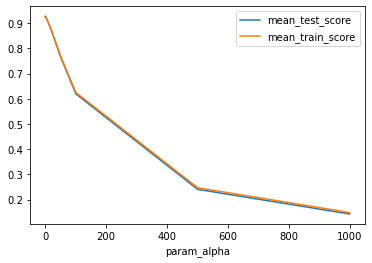

In [9]:
ridge = Ridge() 
params = {'alpha': [1e-20,1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 50, 100, 500, 1000]} 

grid = GridSearchCV(ridge, params, cv = 3, verbose = 0, return_train_score = True)
grid_fit = grid.fit(X_train, Y_train)

grid_results = pd.DataFrame(grid_fit.cv_results_)

grid_results.plot('param_alpha',y=['mean_test_score','mean_train_score'])

>**Observation** 
>>As alpha moves away from 0, the performance of the model gets worse.  
Hence, the best alpha lies arround 0. 

>>We don't see any significant improvement in the scores.  
It doesn't matter how alpha gets larger, the difference between R2(train) and R2(test) remains constant

In [10]:
best_ridge_estimator = grid_fit.best_estimator_
print(f' best estimator : {best_ridge_estimator}')

y_train_pred, y_test_pred= grid_fit.predict(X_train), grid_fit.predict(X_test)
mse_train, mse_test = mean_squared_error(Y_train,y_train_pred ), mean_squared_error(Y_test, y_test_pred)
r2_train, r2_test = r2_score(Y_train,y_train_pred), r2_score(Y_test, y_test_pred)
adjR2_train, adjR2_test = MyFunct.adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]), MyFunct.adjusted_r2(r2_test, X_train.shape[0], X_train.shape[1]) 

metrics['Ridge Regressor'] = [np.sqrt(mse_train), np.sqrt(mse_test), r2_train, r2_test, adjR2_train, adjR2_test]
metrics

 best estimator : Ridge(alpha=1e-10)


Dummy Regressor  Linear Regressor  Ridge Regressor
RMSE   Train    567328.360407     152726.329640    153158.986012
       Test     576996.112490     156892.312389    157582.190339
R2     Train         0.000000          0.927530         0.927119
       Test         -0.000009          0.926063         0.925411
ADJ R2 Train        -0.010028          0.926803         0.926388
       Test         -0.010037          0.925322         0.924663

## Lasso Regressor 

<AxesSubplot:xlabel='param_alpha'>

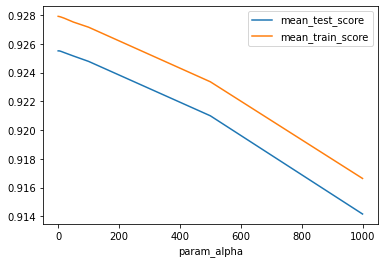

In [11]:
lasso = Lasso() 
params = {'alpha': [1e-20,1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20,50,100, 500, 1000]} 

grid = GridSearchCV(lasso, params, cv = 3, verbose = 0, return_train_score = True)
grid_fit = grid.fit(X_train, Y_train)

grid_results = pd.DataFrame(grid_fit.cv_results_)
grid_results.plot('param_alpha',y=['mean_test_score','mean_train_score'])

**Observation** with the lasso, we don't see any significant improvement in the scores.  
It doesn't matter how alpha gets larger, the difference between R2(train) and R2(test) is approximately constant

In [12]:
best_lasso_estimator = grid_fit.best_estimator_
print(f' best estimator : {best_lasso_estimator}')

y_train_pred, y_test_pred= grid_fit.predict(X_train), grid_fit.predict(X_test)
mse_train, mse_test = mean_squared_error(Y_train,y_train_pred ), mean_squared_error(Y_test, y_test_pred)
r2_train, r2_test = r2_score(Y_train,y_train_pred), r2_score(Y_test, y_test_pred)
adjR2_train, adjR2_test = MyFunct.adjusted_r2(r2_train, X_train.shape[0], X_train.shape[1]), MyFunct.adjusted_r2(r2_test, X_train.shape[0], X_train.shape[1]) 

metrics['Lasso Regressor'] = [np.sqrt(mse_train), np.sqrt(mse_test), r2_train, r2_test, adjR2_train, adjR2_test ]
metrics

 best estimator : Lasso(alpha=1)


Dummy Regressor  Linear Regressor  Ridge Regressor  \
RMSE   Train    567328.360407     152726.329640    153158.986012   
       Test     576996.112490     156892.312389    157582.190339   
R2     Train         0.000000          0.927530         0.927119   
       Test         -0.000009          0.926063         0.925411   
ADJ R2 Train        -0.010028          0.926803         0.926388   
       Test         -0.010037          0.925322         0.924663   

              Lasso Regressor  
RMSE   Train    152731.581165  
       Test     156919.292010  
R2     Train         0.927525  
       Test          0.926038  
ADJ R2 Train         0.926798  
       Test          0.925296

<AxesSubplot:xlabel='RMSE'>

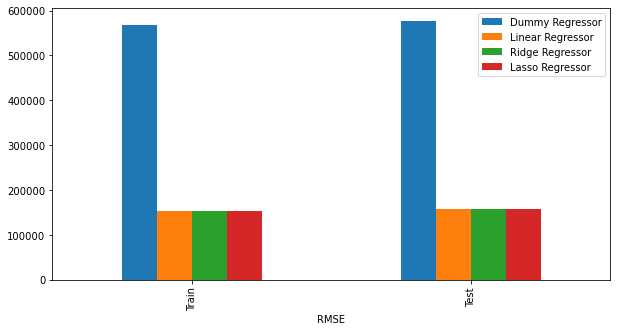

In [13]:
metrics.loc['RMSE'].plot(kind='bar', xlabel='RMSE', figsize=(10,5))

<AxesSubplot:xlabel='R2'>

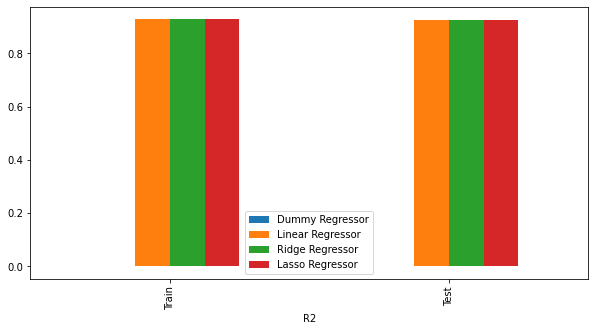

In [14]:
metrics.loc['R2'].plot(kind='bar', xlabel='R2', figsize=(10,5))

>**Conclusion 1** : 
>>There is **no difference** in performance between the unregularized Linear regression model (alpha =0) and the regularized linear regression models

>> Anyway, the linear regressor gives good performance indicators and it seems that there no overfitting.

## Features Importance

In [15]:
dataset.Store.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.])

In [16]:
dataset.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Week'],
      dtype='object')

In [ ]:
coef = pd.DataFrame()
coef['feature'] = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week'] + ['Store_%d'%i for i in range(2,46)]+ ['Holiday_Flag']

coef['coef_linear_regressor'] = linear_regressor.coef_
coef['coef_linear_regressor'] = coef.coef_linear_regressor.abs()
coef = coef.sort_values(by = 'coef_linear_regressor', ascending = True)

px.bar(coef, x ='coef_linear_regressor', y = 'feature')

<img src="Viz/coef_1.png">

In [18]:
coef = pd.DataFrame()
coef['feature'] = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week']+ ['Holiday_Flag']+ ['Store_%d'%i for i in range(2,8)]

coef['coef_linear_regressor'] = [*list(linear_regressor.coef_[0:5]),linear_regressor.coef_[-1], *list(linear_regressor.coef_[5:11])]
coef['coef_linear_regressor'] = coef.coef_linear_regressor.abs()
coef = coef.sort_values(by = 'coef_linear_regressor', ascending = True)

px.bar(coef, x ='coef_linear_regressor', y = 'feature')

<img src="Viz/coef_2.png">

In [19]:
coef = pd.DataFrame()
coef['feature'] = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week']+ ['Holiday_Flag']+ ['Store_%d'%i for i in range(2,8)]

coef['coef_best_lasso_estimator'] = [*list(best_lasso_estimator.coef_[0:5]),best_lasso_estimator.coef_[-1], *list(best_lasso_estimator.coef_[5:11])]
coef['coef_best_lasso_estimator'] = coef.coef_best_lasso_estimator.abs()
coef = coef.sort_values(by = 'coef_best_lasso_estimator', ascending = True)

px.bar(coef, x ='coef_best_lasso_estimator', y = 'feature')

<img src="Viz/coef_3.png">

# Summary

>>The stores has a great impact on the prediction!!!   

>> Propose another model that do not use stores as predictors

In [20]:
# save the performance indicators computed so far
import csv
metrics.to_csv(results_path+"metrics.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)